### Import & Process Image

In [370]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import cv2
import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

In [315]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [336]:
def import_dataset(img_path, data_path):
    img_names = sorted(glob.glob(img_path+"/*.jpg"))
    csv_names = [i for i in glob.glob(data_path+'/*.csv')]
    df = pd.concat([pd.read_csv(f) for f in csv_names]).sort_values('name').reset_index(drop=True)
    df['image'] = img_names
    return df

def clean_dataset(df):
    dataset = df.copy()
    dataset = dataset[['meta.clinical.diagnosis', 'image']]
    dataset = dataset[dataset['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
    dataset.columns = ['diagnosis', 'image']
    dataset['diagnosis'] = (dataset['diagnosis'] == 'melanoma').astype(int)
    return dataset

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in test_df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set

In [348]:
# Importing and creating test set. Returns X & y.
test_df = import_dataset('img/img_test','data/data_test')
test_df_cleaned = clean_dataset(test_df)
X_test, y_test = create_X_y(test_df_cleaned)

#### Creating Train Set

In [317]:
# Train Set
path = "img/img_train"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

# Train Set
negative_csv =[i for i in glob.glob('data/data_train/0/*.csv')]
positive_csv =[i for i in glob.glob('data/data_train/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [318]:
# Train Set
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [319]:
# Create X and y for Train set
y = lbl_img_cl['diagnosis']
X = []
for i in fileimages:
    image = load_and_preprocess_image(i)
    X.append(np.asarray(image))

In [320]:
# Train/test split for Train Set
X_train, X_val, y_train, y_val = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)

### Train Model

In [355]:
def train_model(X_train, y_train, model_type=keras.Sequential(), input_shape=(100,100,3), activation='softmax', epochs=10):
    model = model_type
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.Dense(2, activation=activation))
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs)
    return model

In [356]:
model = train_model(X_train, y_train)

Epoch 1/10
25/25 [==============================] - 0s 5ms/step - loss: 2.3303 - accuracy: 0.5727
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 1.1877 - accuracy: 0.5501
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 1.0740 - accuracy: 0.6015
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 1.2049 - accuracy: 0.5927
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.8243 - accuracy: 0.6416
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.9881 - accuracy: 0.5940
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 1.1877 - accuracy: 0.5777
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 0.7316 - accuracy: 0.6754
Epoch 9/10
25/25 [==============================] - 0s 4ms/step - loss: 1.1365 - accuracy: 0.5714
Epoch 10/10
25/25 [==============================] - 0s 3ms/step - loss: 1.3061 - accuracy: 0.5777


In [362]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 60002     
Total params: 60,002
Trainable params: 60,002
Non-trainable params: 0
_________________________________________________________________


## Evalaution

### Base Model (Dumb Model)

In [121]:
ones = np.count_nonzero(y_test)
zeros = np.count_nonzero(y_test==0)
total = len(y_test)
dumb_pred = np.zeros(total)

In [199]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.2f}'.format(tp/(tp+fn)))
    print('Precision: {:.2f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.2f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.2f}'.format(roc_auc_score(y_test, y_pred)))

In [200]:
matrix_score(y_test, dumb_pred)

[[  0  32]
 [  0 148]]
Recall:    0.00
Precision: nan
Accuracy:  0.82
ROC AUC:   0.50


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


### Validation Set and Test Set

In [367]:
# Validation Set
val_loss1, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Validation set accuracy {:5.2f}%'.format(100*val_acc))

# Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))

Validation set accuracy 67.00%
Test set accuracy 60.33%


In [368]:
# Validation Set
y_val_pred = np.argmax(model.predict(X_val), axis=-1)
matrix_score(y_val, y_val_pred)

[[52 48]
 [18 82]]
Recall:    0.52
Precision: 0.74
Accuracy:  0.67
ROC AUC:   0.67


In [369]:
# Test Set
y_test_pred = np.argmax(model.predict(X_test), axis=-1)
matrix_score(y_test, y_test_pred)

[[ 11  66]
 [ 53 170]]
Recall:    0.14
Precision: 0.17
Accuracy:  0.60
ROC AUC:   0.45


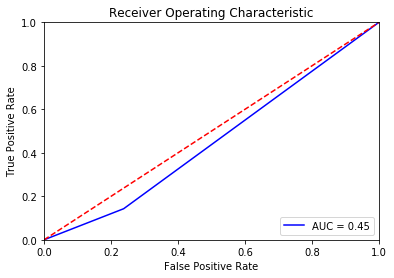

In [361]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [245]:
## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(fileimages)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

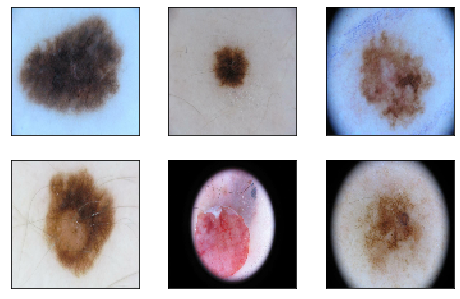

In [234]:
plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(6)):
    plt.subplot(3,3,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])